# Problem Statment
To create the service for to categorise the genre of the movie based on the provided overview by the creator. For this purpose,use The Movies Dataset, which contains historical information on previously published movies, including overviews and associated genres.


### Importing Libraries

To solve the problem statement , let us setup the environment and import the necessary libraries such as:

`pandas`: for reading and understanding the data,

`numpy`: for doing numerical computations on the data,

`matplotlib and seaborn`: for Graphical visualizations

`BeautifulSoup`: for pulling data out of HTML and XML files and remove the unnessary tags and helps in navigating, searching, and modifying the parse tree data,

`re`: is the library for regular expression and we are going to use it to clean out data and based on pattern matching using regular expressions

`spaCy`: which is a free open-source library for Natural Language Processing in Python. It features NER, POS tagging, dependency parsing, word vectors and more.

`sklearn`: is used for all mahine learning tasks such as here we are using it to training models and predicting it's performance.

In [1]:
# libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import ast
import pickle

# wordscloud
from wordcloud import WordCloud


# spacy
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# graphviz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 101)

# warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the Data and Exploratory Data Analysis(EDA)

In [2]:
# Read the Dataset
df = pd.read_csv("data/movies_metadata.csv")
print(df.shape)
df.head(3)

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [3]:
df = df[['overview','genres']]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   overview  44512 non-null  object
 1   genres    45466 non-null  object
dtypes: object(2)
memory usage: 710.5+ KB


In [5]:
#Convert from object genres into the list 
df['genres'] = df['genres'].apply(ast.literal_eval)

In [6]:
#Check for the nulls
df.isnull().sum()

overview    954
genres        0
dtype: int64

In [7]:
# Drop the null values where `overview` is null
df = df.dropna(subset=['overview'])

# Remove the columns where the genres list is empty
df = df[df['genres'].map(lambda d: len(d)) > 0]

df.reset_index(drop=True,inplace=True)

In [8]:
df.genres.describe()

count                             42327
unique                             4048
top       [{'id': 18, 'name': 'Drama'}]
freq                               4910
Name: genres, dtype: object

### Using Spacy to Preprocess Text Data

In [9]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [10]:
#  Tokenizer function
def spacy_tokenizer(sentence):
    
    """Function for preprocessing steps to create the tokens
    """ 
    
    # Create token object, which is used to create documents with linguistic annotations.
    # Beautifying the text of HTML and XML data 
    review_soup = BeautifulSoup(sentence)
    
    # Get the text and remove the tags
    review_text = review_soup.get_text()
    
    #Remove the letters anf punctations 
    review_letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    #Convert to lower case
    review_lower_case = review_letters_only.lower()  
    
    #Splits into words
    review_words = review_lower_case.split() 
    
    # Remove stopwords
    meaningful_words = [ word for word in review_words if word not in stop_words]
    
    return ' '.join(meaningful_words)



In [11]:
df['overview_new'] = df.overview.apply(spacy_tokenizer)

In [12]:
df['genre_new'] = df['genres'].apply(lambda x: [v for dic in x for k,v in dic.items() if 'name' in k])

### MultiLabelBinarizer for Genres

In [13]:
#initialize MultiLabelBinarizer 
mlb = MultiLabelBinarizer() 

#transform the genre_new column to a series of columns with binary values
binary_labels=pd.DataFrame(mlb.fit_transform(df['genre_new']),columns=mlb.classes_) 

#order columns alphabetically
binary_labels=binary_labels.sort_index(axis=1) 

binary_labels.tail()

,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western
42322,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
42323,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
42324,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42325,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42326,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [14]:
#bring data frames together
movies = df.merge(binary_labels, how='inner', left_index=True, right_index=True)

#Drop non-properly formatted columns
movies= movies.drop(columns=['genres','overview','genre_new'])

movies.tail(2)

,overview_new,Action,Adventure,Animation,Aniplex,BROSTA TV,Carousel Productions,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,GoHands,History,Horror,Mardock Scramble Production Committee,Music,Mystery,Odyssey Media,Pulser Productions,Rogue State,Romance,Science Fiction,Sentai Filmworks,TV Movie,Telescene Film Group Productions,The Cartel,Thriller,Vision View Entertainment,War,Western
42325,artist struggles finish work storyline cult pl...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42326,hits goes wrong professional assassin ends sui...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [15]:
missing_values_check = movies.isnull().sum()
print(missing_values_check)

overview_new                             0
Action                                   0
Adventure                                0
Animation                                0
Aniplex                                  0
BROSTA TV                                0
Carousel Productions                     0
Comedy                                   0
Crime                                    0
Documentary                              0
Drama                                    0
Family                                   0
Fantasy                                  0
Foreign                                  0
GoHands                                  0
History                                  0
Horror                                   0
Mardock Scramble Production Committee    0
Music                                    0
Mystery                                  0
Odyssey Media                            0
Pulser Productions                       0
Rogue State                              0
Romance    

### Word Cloud

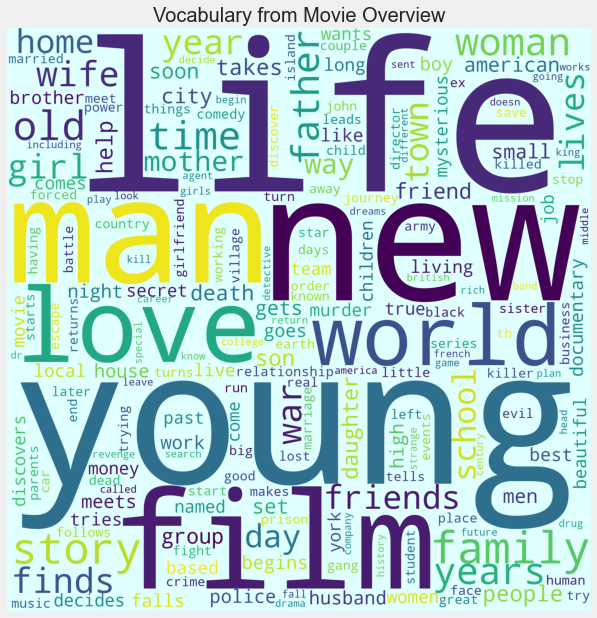

In [16]:
# wordcloud of the words present in the data
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(movies['overview_new'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Movie Overview", fontsize = 20)
plt.show()


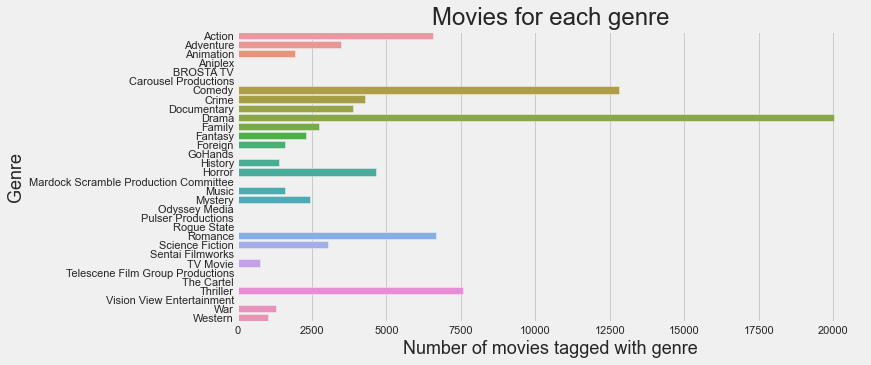

In [17]:
categories = list(binary_labels.columns.values)
ax= sns.barplot(binary_labels.sum().values, categories)

plt.title("Movies for each genre", fontsize=24)
plt.ylabel('Genre', fontsize=18)
plt.xlabel('Number of movies tagged with genre', fontsize=18)
#adding the text labels
rects = ax.patches
labels = binary_labels.sum().values
plt.show()

In [18]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, movies[category].sum()))
df_stats = pd.DataFrame(counts, columns=['genres', 'number of overiews'])
df_stats.sort_values('number of overiews',ascending=False)

,genres,number of overiews
9,Drama,20023
6,Comedy,12806
28,Thriller,7586
22,Romance,6673
0,Action,6565
15,Horror,4660
7,Crime,4269
8,Documentary,3886
1,Adventure,3470
23,Science Fiction,3028


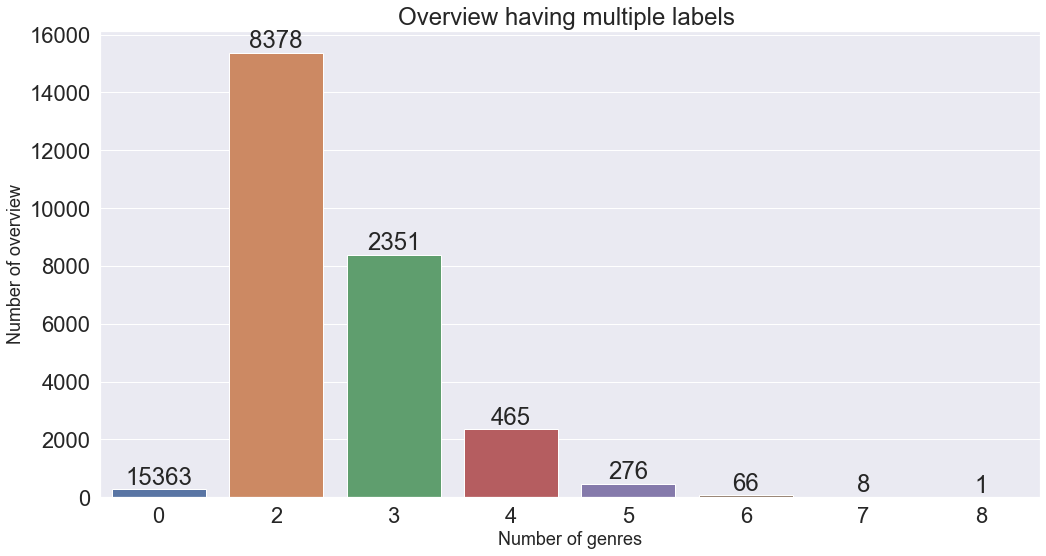

In [19]:
rowSums = movies.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Overview having multiple labels ")
plt.ylabel('Number of overview', fontsize=18)
plt.xlabel('Number of genres', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

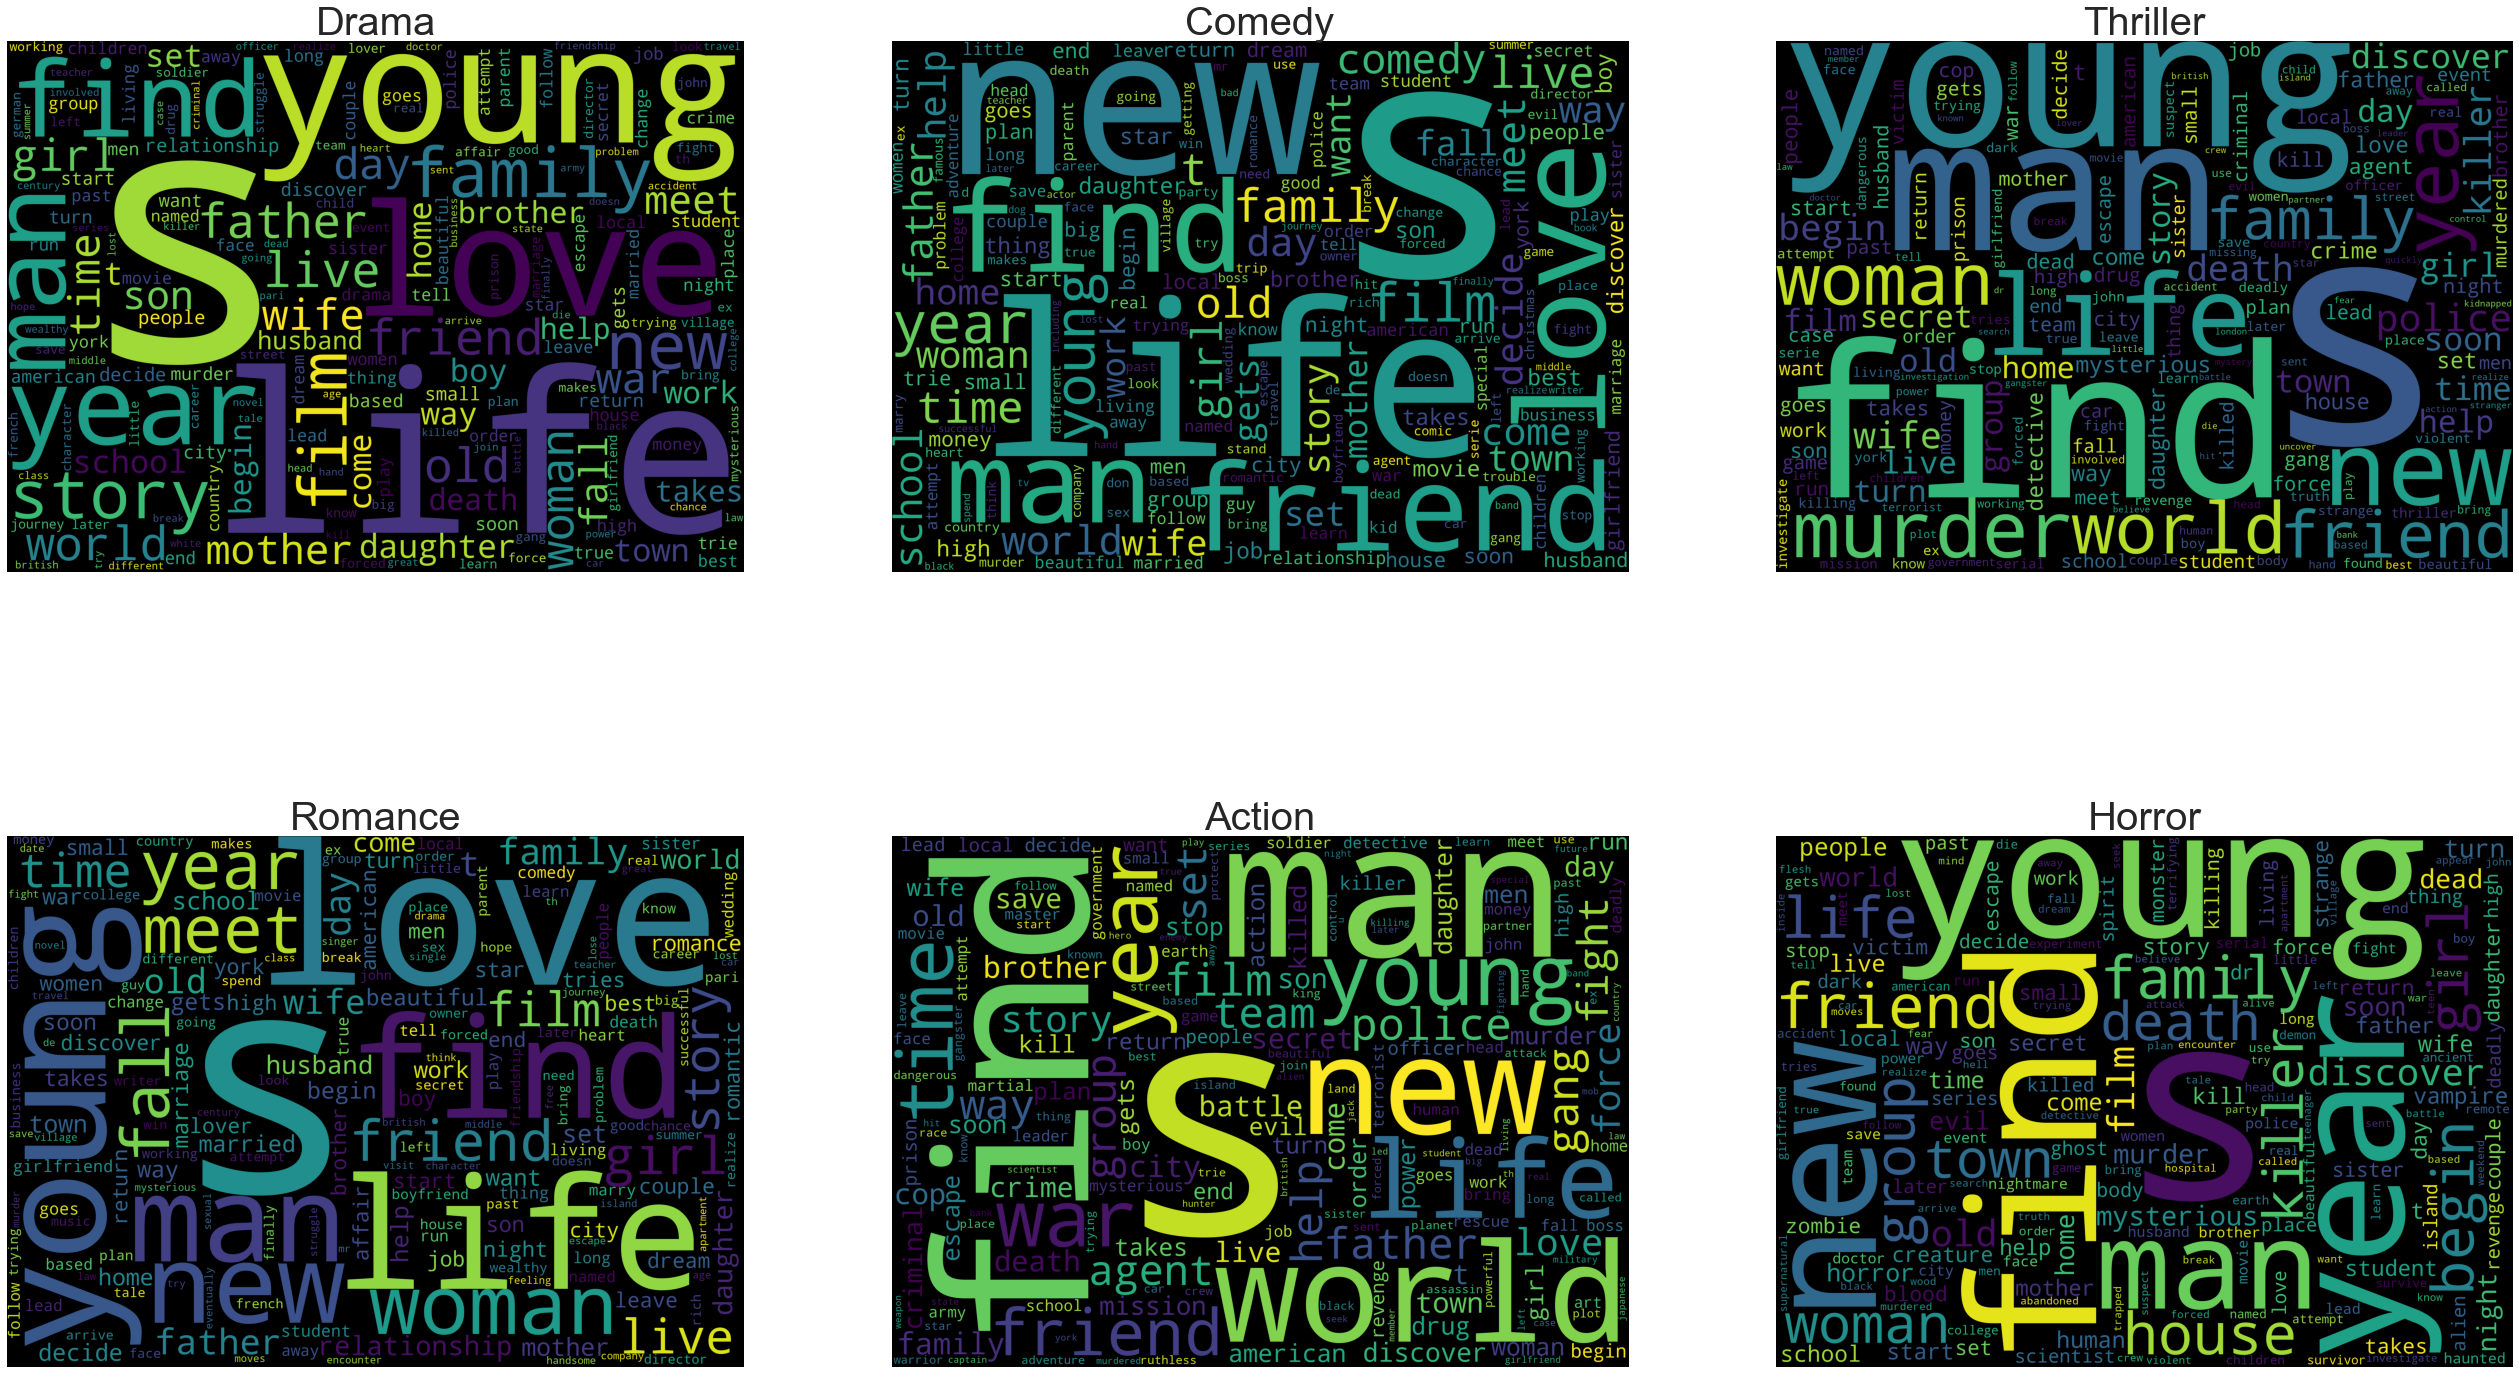

In [20]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# Drama
subset = movies[movies.Drama==1]
text = subset.overview_new.values
cloud_Drama = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Drama",fontsize=40)
plt.imshow(cloud_Drama)


# Comedy
subset = movies[movies.Comedy==1]
text = subset.overview_new.values
cloud_Comedy = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Comedy",fontsize=40)
plt.imshow(cloud_Comedy)


# Thriller

subset = movies[movies.Thriller==1]
text = subset.overview_new.values
cloud_Thriller = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Thriller",fontsize=40)
plt.imshow(cloud_Thriller)


# Romance

subset = movies[movies.Romance==1]
text = subset.overview_new.values
cloud_Romance = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Romance",fontsize=40)
plt.imshow(cloud_Romance)


# Action
subset = movies[movies.Action==1]
text = subset.overview_new.values
cloud_Action = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Action",fontsize=40)
plt.imshow(cloud_Action)


# Horror
subset = movies[movies.Horror==1]
text = subset.overview_new.values
cloud_Horror = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Horror",fontsize=40)
plt.imshow(cloud_Horror)

plt.show()

## Visualization, Modeling, Machine Learning
### Used Different Classification Models which is performing best based on Accuracy

In [21]:

# split dataset into training and validation set
X_train, X_val, y_train, y_val = train_test_split(movies['overview_new'], 
                                              binary_labels, 
                                              test_size=0.2, 
                                              random_state=9)

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
# https://en.wikipedia.org/wiki/Tf%E2%80%93idfs
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [22]:
# Use all the Classifiers to check which is performing best
algos = [
          "RandomForestClassifier",
          "Decision Tree",
          "Logistic Regression",
          "Naive Bayes"
        ]
        
clfs = [
        RandomForestClassifier(),
        DecisionTreeClassifier(),
        OneVsRestClassifier(LogisticRegression()),
        OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))
       ]
         
result = []

for clff in clfs:
    clff.fit(X_train_tfidf,y_train)
    acc = clff.score(X_val_tfidf,y_val)
    y_pred = clff.predict(X_val_tfidf)
    result.append(acc)

# accuracy of different Classifiers
result_df = pd.DataFrame(result,index=algos)
result_df.columns=["Accuracy"]
result_df.sort_values(by=["Accuracy"],ascending= False)

,Accuracy
Logistic Regression,0.194307
RandomForestClassifier,0.161351
Naive Bayes,0.153792
Decision Tree,0.119301


### Train the Data using Best Classifier Identify Above

In [23]:
# Best Class Classifier : Logistic Regression to be used to training and testing the data

classifier = OneVsRestClassifier(LogisticRegression(penalty='l2',
                                solver='sag',
                                C=1.0,
                                random_state=33))

classifier.fit(X_train_tfidf,y_train)

OneVsRestClassifier(estimator=LogisticRegression(random_state=33, solver='sag'))

In [24]:
predictions = classifier.predict(X_val_tfidf)

### Classification Report
A classification report is a performance evaluation metric in machine learning. It is used to show the precision, recall, F1 Score, and support of your trained classification model.

In [25]:
#Show precision and recall per genre
print(classification_report(y_val, predictions, target_names=binary_labels.columns))

                                       precision    recall  f1-score   support

                               Action       0.74      0.31      0.43      1320
                            Adventure       0.70      0.11      0.19       709
                            Animation       0.92      0.09      0.17       353
                              Aniplex       0.00      0.00      0.00         0
                            BROSTA TV       0.00      0.00      0.00         0
                 Carousel Productions       0.00      0.00      0.00         0
                               Comedy       0.73      0.42      0.53      2572
                                Crime       0.65      0.20      0.30       885
                          Documentary       0.91      0.48      0.63       770
                                Drama       0.69      0.68      0.69      3929
                               Family       0.76      0.10      0.18       558
                              Fantasy       0.75   

### Save Model

In [26]:
# save the model
pickle.dump(classifier, open('model/log_model.pkl','wb'))
# save the MultiLabelBinarizer
pickle.dump(mlb, open('model/mlb.pkl', 'wb'))

#save the vectorzier
pickle.dump(tfidf_vectorizer, open('model/tfidf_vectorizer.pkl', 'wb'))